In [1]:
%run ../input/python-recipes/radial_gradient_header.py
%radial_gradient_header Code Modules & Settings|24

In [2]:
import os,pandas as pd,numpy as np,pylab as pl
import torch,tensorflow_hub as th,tensorflow as tf
import tensorflow.keras.layers as tkl
import tensorflow.keras.callbacks as tkc
from tensorflow.keras.preprocessing import image as tkimg
from torch.utils.data import DataLoader as tdl
from torch.utils.data import Dataset as tds
from torchvision import transforms,utils,models
import torch.nn.functional as tnnf
import torch.nn as tnn
from tqdm import tqdm
from IPython.display import display,HTML
file_path='../input/white-flowers/white_flowers/'
file_weights='/tmp/checkpoint'
batch_size,batch_size2=16,10
img_size,img_size2=224,64
crop_size=(img_size2,img_size2)
c1,c2='#11ccee','#cc11ee'
dev=torch.device('cuda:0' \
if torch.cuda.is_available() else 'cpu')
classes=['jasmine','phlox','leucanthemum maximum','cherry',
         'viola','lily of the valley','apple tree',
         'snowdrop','perennial aster','blackberry',
         'strawberry','Nanking cherry','bellflower']

In [3]:
%radial_gradient_header Data Processing|24

In [4]:
def paths2tensor(img_paths,file_path,img_size):
    tensor=[]
    for img_path in tqdm(img_paths):
        img0=tkimg.load_img(
            file_path+img_path,
            target_size=(img_size,img_size))
        img=tkimg.img_to_array(img0)
        tensor.append(np.expand_dims(img,axis=0))
    return np.vstack(tensor)/255

In [5]:
file_list=sorted(os.listdir(file_path))
y=np.array([int(el[:2]) for el in file_list],
           dtype=np.int8)-1
num_classes=len(set(y)) 
x=np.array(paths2tensor(
    file_list,file_path=file_path,img_size=img_size),
    dtype=np.float32)
N=y.shape[0]; n=int(.1*N)
shuffle_ids=np.arange(N)
np.random.RandomState(12).shuffle(shuffle_ids)
x,y=x[shuffle_ids],y[shuffle_ids]
x_test,x_valid,x_train=x[:n],x[n:2*n],x[2*n:]
y_test,y_valid,y_train=y[:n],y[n:2*n],y[2*n:]
pd.DataFrame([[x_train.shape,x_valid.shape,x_test.shape],
              [x_train.dtype,x_valid.dtype,x_test.dtype],
              [y_train.shape,y_valid.shape,y_test.shape],
              [y_train.dtype,y_valid.dtype,y_test.dtype]],               
             columns=['train','valid','test'])

100%|██████████| 514/514 [01:54<00:00,  4.48it/s]


,train,valid,test
0,"(412, 224, 224, 3)","(51, 224, 224, 3)","(51, 224, 224, 3)"
1,float32,float32,float32
2,"(412,)","(51,)","(51,)"
3,int8,int8,int8


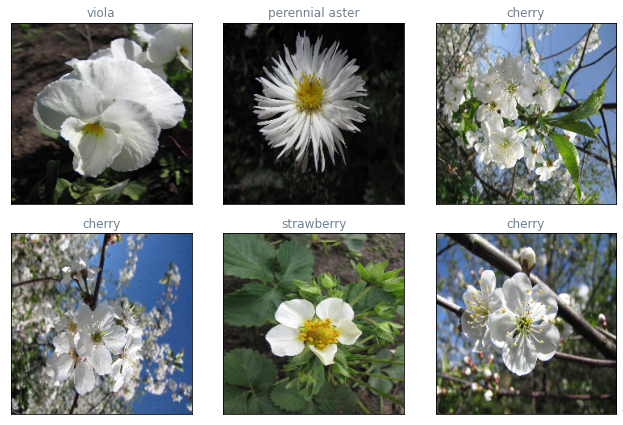

In [6]:
def display_imgs(images,labels,names):
    fig=pl.figure(figsize=(9,6))
    n=np.random.randint(0,3)
    for i in range(n,n+6):
        ax=fig.add_subplot(2,3,i-n+1,xticks=[],yticks=[])
        ax.set_title(
            names[labels[i]],color='slategray',
            fontdict={'fontsize':'large'})
        ax.imshow((images[i]))
    pl.tight_layout(); pl.show()
display_imgs(x,y,classes)

In [7]:
%radial_gradient_header TensorFlow Hub Quick Classification|24

In [8]:
def premodel(img_size,dense,mh,num_classes,activ,loss):
    model=tf.keras.Sequential([
        tkl.Input((img_size,img_size,3),name='input'),
        th.KerasLayer(mh,trainable=True),
        tkl.Flatten(),
        tkl.Dense(dense,activation='relu'),
        tkl.Dropout(rate=.5),
        tkl.Dense(num_classes,activation=activ)])
    model.compile(optimizer='adam',loss=loss,
                  metrics=['accuracy'])
    display(model.summary())
    return model
def cb(file_weights):
    early_stopping=tkc.EarlyStopping(
        monitor='val_loss',patience=5,verbose=2)
    checkpointer=tkc.ModelCheckpoint(
        filepath=file_weights,verbose=2,save_weights_only=True,
        monitor='val_accuracy',mode='max',save_best_only=True)
    lr_reduction=tkc.ReduceLROnPlateau(
        monitor='val_loss',verbose=2,patience=3,factor=.8)
    return [checkpointer,early_stopping,lr_reduction]

In [9]:
handle_base='mobilenet_v2_130_224'
mhandle='https://tfhub.dev/google/imagenet/{}'.format(handle_base)+\
        '/feature_vector/4'
model=premodel(img_size,2048,mhandle,num_classes,
               'softmax','sparse_categorical_crossentropy')
history=model.fit(x=x_train,y=y_train,
                  batch_size=batch_size,epochs=10,
                  callbacks=cb(file_weights),
                  validation_data=(x_valid,y_valid))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1664)              3766048   
_________________________________________________________________
flatten (Flatten)            (None, 1664)              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              3409920   
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 13)                26637     
Total params: 7,202,605
Trainable params: 7,158,349
Non-trainable params: 44,256
_________________________________________________________________


None

Epoch 1/10
26/26 [==============================] - 96s 3s/step - loss: 2.3233 - accuracy: 0.4900 - val_loss: 10.1892 - val_accuracy: 0.4510

Epoch 00001: val_accuracy improved from -inf to 0.45098, saving model to /tmp/checkpoint
Epoch 2/10
26/26 [==============================] - 85s 3s/step - loss: 0.7652 - accuracy: 0.8061 - val_loss: 3.0407 - val_accuracy: 0.6667

Epoch 00002: val_accuracy improved from 0.45098 to 0.66667, saving model to /tmp/checkpoint
Epoch 3/10
26/26 [==============================] - 94s 4s/step - loss: 0.8558 - accuracy: 0.7999 - val_loss: 22.2283 - val_accuracy: 0.2941

Epoch 00003: val_accuracy did not improve from 0.66667
Epoch 4/10
26/26 [==============================] - 86s 3s/step - loss: 0.9790 - accuracy: 0.8051 - val_loss: 13.6984 - val_accuracy: 0.3137

Epoch 00004: val_accuracy did not improve from 0.66667
Epoch 5/10
26/26 [==============================] - 86s 3s/step - loss: 0.6274 - accuracy: 0.8580 - val_loss: 6.4252 - val_accuracy: 0.6275

E

In [10]:
model.load_weights(file_weights)
model.evaluate(x_test,y_test)

2/2 [==============================] - 1s 514ms/step - loss: 5.2646 - accuracy: 0.6863


[5.264570236206055, 0.686274528503418]

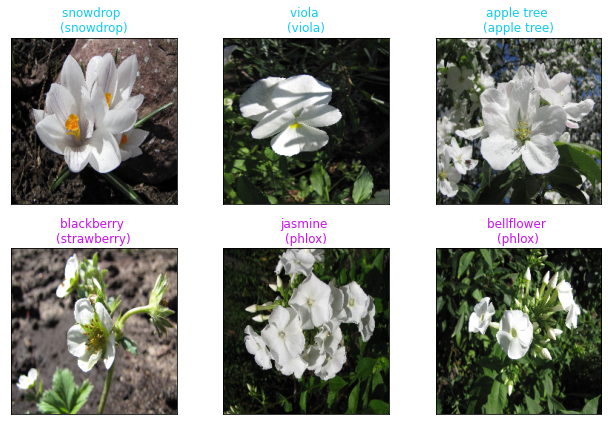

In [11]:
y_test_predict=np.argmax(model.predict(x_test),axis=-1)
fig=pl.figure(figsize=(9,6))
randch=np.random.choice(
    x_test.shape[0],size=6,replace=False)
for i,idx in enumerate(randch):
    ax=fig.add_subplot(2,3,i+1,xticks=[],yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx=y_test_predict[idx]
    true_idx=y_test[idx]
    ax.set_title('{} \n({})'\
    .format(classes[pred_idx],classes[true_idx]),
    color=(c1 if pred_idx==true_idx else c2))
pl.tight_layout(); pl.show()

In [12]:
%radial_gradient_header PyTorch Datasets|24

In [13]:
class TData(tds):
    def __init__(self,x,y):   
        self.x=torch.tensor(x,dtype=torch.float32)
        self.y=torch.tensor(y,dtype=torch.int32)
    def __getitem__(self,index):
        img,lbl=self.x[index],self.y[index]
        return img,lbl
    def __len__(self):
        return self.y.shape[0]
n_train=batch_size2*(x_train.shape[0]//batch_size2)
x_train2=np.transpose(x_train,(0,3,1,2))[:n_train]
print(x_train2.mean(),x_train2.std())
n_valid=batch_size2*(x_valid.shape[0]//batch_size2)
x_valid2=np.transpose(x_valid,(0,3,1,2))[:n_valid]
n_test=batch_size2*(x_test.shape[0]//batch_size2)
x_test2=np.transpose(x_test,(0,3,1,2))[:n_test]
random_seed=23
train2=TData(x_train2,y_train[:n_train])
valid2=TData(x_valid2,y_valid[:n_valid])
test2=TData(x_test2,y_test[:n_test])
dataloaders={'train':tdl(dataset=train2,shuffle=True,
                         batch_size=batch_size2), 
             'valid':tdl(dataset=valid2,shuffle=True,
                         batch_size=batch_size2),
             'test':tdl(dataset=test2,shuffle=True,
                        batch_size=batch_size2)}

0.35343876 0.2764085


image dimensions: torch.Size([10, 3, 224, 224])
label dimensions: torch.Size([10])


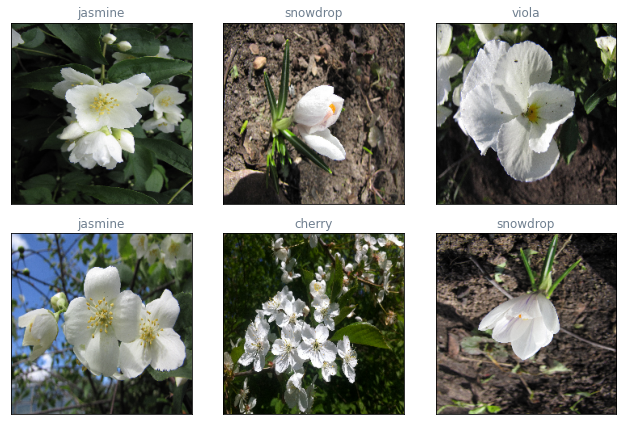

In [14]:
@register_line_magic
def display_data_imgs(data):
    global classes
    for images,labels in dataloaders[data]:  
        print('image dimensions: %s'%str(images.shape))
        print('label dimensions: %s'%str(labels.shape))
        images=[np.transpose(images[i],(1,2,0)) 
                for i in range(len(images))]
        display_imgs(images,labels,classes)
        break
%display_data_imgs valid

In [15]:
%radial_gradient_header PyTorch Models|24

In [16]:
def model_acc(model,data_loader):
    correct_preds,num_examples=0,0    
    for features,targets in data_loader:
        features=features.to(dev)
        targets=targets.to(dev).long()
        logits=model(features)
        _,pred_labels=torch.max(logits,1)
        num_examples+=targets.size(0)
        correct_preds+=(pred_labels==targets).sum()        
    return correct_preds.float()/num_examples*100
def epoch_loss(model,data_loader):
    model.eval()
    curr_loss,num_examples=0.,0
    with torch.no_grad():
        for features,targets in data_loader:
            features=features.to(dev)
            targets=targets.to(dev).long()
            logits=model(features)
            loss=tnnf.cross_entropy(logits,targets,
                                    reduction='sum')
            num_examples+=targets.size(0)
            curr_loss+=loss
        return curr_loss/num_examples

In [17]:
tmodel=models.vgg16(pretrained=True)
for param in tmodel.parameters():
    param.requires_grad=False
tmodel.classifier[3].requires_grad=True
tmodel.classifier[6]=tnn.Sequential(
    tnn.Linear(4096,512),tnn.ReLU(),
    tnn.Dropout(.5),tnn.Linear(512,num_classes))
tmodel=tmodel.to(dev)
optimizer=torch.optim.Adam(tmodel.parameters())

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [18]:
@register_line_magic
def train_run(epochs):
    epochs=int(epochs)
    str1='epoch: %03d/%03d || batch: %03d/%03d || cost: %.4f'
    str2='train acc/loss: %.2f%%/%.2f || valid acc/loss: %.2f%%/%.2f'
    for epoch in range(epochs):
        tmodel.train()
        for batch_ids,(features,targets) \
        in enumerate(dataloaders['train']):        
            features=features.to(dev)
            targets=targets.to(dev).long()
            logits=tmodel(features)
            cost=tnnf.cross_entropy(logits,targets)
            optimizer.zero_grad(); cost.backward()
            optimizer.step()
            if not batch_ids%10:
                print(str1%(epoch+1,epochs,batch_ids,
                            len(dataloaders['train']),cost))
        tmodel.eval()
        with torch.set_grad_enabled(False):
            print('epoch: %03d/%03d'%(epoch+1,epochs))
            print(str2%\
                  (model_acc(tmodel,dataloaders['train']),
                   epoch_loss(tmodel,dataloaders['train']),
                   model_acc(tmodel,dataloaders['valid']),
                   epoch_loss(tmodel,dataloaders['valid']))) 

In [19]:
%train_run 10

epoch: 001/010 || batch: 000/041 || cost: 2.6876
epoch: 001/010 || batch: 010/041 || cost: 2.1457
epoch: 001/010 || batch: 020/041 || cost: 1.3595
epoch: 001/010 || batch: 030/041 || cost: 1.5627
epoch: 001/010 || batch: 040/041 || cost: 1.3636
epoch: 001/010
train acc/loss: 78.05%/0.92 || valid acc/loss: 76.00%/0.92
epoch: 002/010 || batch: 000/041 || cost: 1.0556
epoch: 002/010 || batch: 010/041 || cost: 0.8174
epoch: 002/010 || batch: 020/041 || cost: 0.7326
epoch: 002/010 || batch: 030/041 || cost: 0.9113
epoch: 002/010 || batch: 040/041 || cost: 1.0808
epoch: 002/010
train acc/loss: 85.37%/0.55 || valid acc/loss: 82.00%/0.56
epoch: 003/010 || batch: 000/041 || cost: 0.5671
epoch: 003/010 || batch: 010/041 || cost: 1.3576
epoch: 003/010 || batch: 020/041 || cost: 0.2980
epoch: 003/010 || batch: 030/041 || cost: 0.3029
epoch: 003/010 || batch: 040/041 || cost: 0.7471
epoch: 003/010
train acc/loss: 92.93%/0.35 || valid acc/loss: 88.00%/0.44
epoch: 004/010 || batch: 000/041 || cost: 0

In [20]:
tmodel.eval()
with torch.set_grad_enabled(False):
    print('train acc: %.2f%% || test acc: %.2f%%'%\
          (model_acc(tmodel,dataloaders['train']),
           model_acc(tmodel,dataloaders['test'])))

train acc: 96.34% || test acc: 82.00%


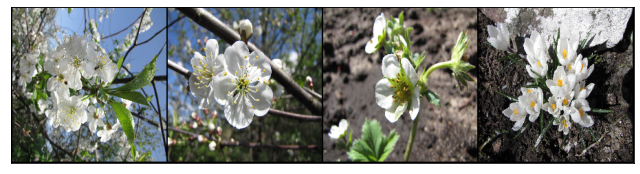

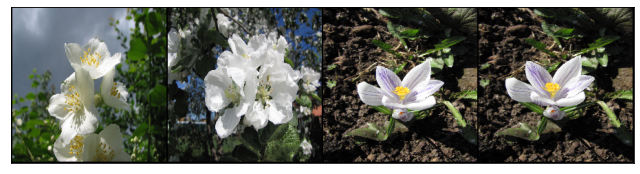

In [21]:
def show_image(img):
    npimg=img.numpy(); tr=(1,2,0)
    pl.figure(figsize=(9,3))
    pl.imshow(np.transpose(npimg,tr))
    pl.xticks([]); pl.yticks([])
    pl.tight_layout(); pl.show()
with torch.no_grad():
    for i,(images,labels) in enumerate(dataloaders['test']):
        show_image(utils.make_grid(images[:4]))
        st0=r'<p style="font-size:16px; color:%s">'
        st1=st0%c1+'true labels:<br/>%s</p>'%''.join(
         '%d) %s; '%(j+1,classes[labels[j]]) for j in range(4))
        images=images.to(dev); labels=labels.to(dev)
        outputs=tmodel(images)
        _,preds=torch.max(outputs,1)
        st2=st0%c2+'predictions:<br/>%s</p>'%''.join(
        '%d) %s; '%(j+1,classes[preds[j]]) for j in range(4))
        display(HTML(st1+st2))
        if i==1: break